# Lab Demonstration 1  
## Fractals with Tensorflow

### Vincent Abbosh /  45019218

In [1]:
import tensorflow as tf
tf.__version__

'1.13.1'

## Part 1

In [2]:
import numpy as np

sess = tf.InteractiveSession()

#### Producing a 2D Gaussian image

In [3]:
X, Y = np.mgrid[-4.0:4:0.01, -4.0:4:0.01]

In [4]:
xs = tf.constant(X.astype(np.float32))
ys = tf.constant(Y.astype(np.float32))

In [5]:
tf.global_variables_initializer().run() #init variables

In [6]:
zs = tf.exp(-(xs**2+ys**2)/2.0)

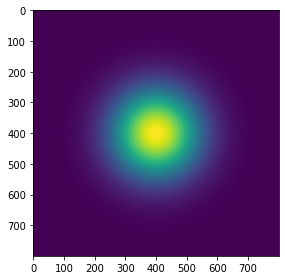

In [8]:
#plot
import matplotlib.pyplot as plt
plt.imshow(zs.eval())
plt.tight_layout()
plt.show()

#### Use $sin(x)$

In [9]:
zs_sin = tf.sin(xs**2 + ys**2)

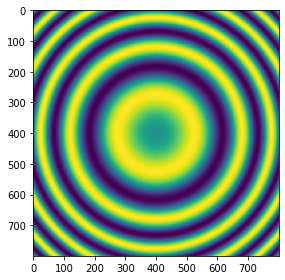

In [16]:
plt.imshow(zs_sin.eval())
plt.tight_layout()
plt.show()

### Plot $e^{-\frac{r^2}{\sigma}}sin(r^2)$

In [17]:
zs_prod = zs * zs_sin

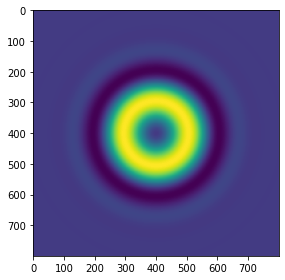

In [18]:
plt.imshow(zs_prod.eval())
plt.tight_layout()
plt.show()

## Part 2

In [19]:
Y1, X1 = np.mgrid[-1.3:1.3:0.001, -2:1:0.001]
Z1 = X1+1j*Y1

In [21]:
xs_const = tf.constant(Z1.astype(np.complex64))
zs_var = tf.Variable(tf.zeros_like(xs_const))
ns_var = tf.Variable(tf.zeros_like(xs_const, tf.float32))

In [22]:
tf.global_variables_initializer().run()

In [23]:
zs_ = zs_var*zs_var + xs_const

In [24]:
not_diverged = tf.abs(zs_) < 2

In [25]:
step = tf.group( zs_var.assign(zs_), ns_var.assign_add(tf.cast(not_diverged, tf.float32)) )

In [26]:
for i in range(200):
    step.run()
    

In [27]:
def processFractal(a):
    """Display an array of iteration counts as a
    colorful picture of a fractal."""
    a_cyclic = (6.28*a/20.0).reshape(list(a.shape)+[1])
    img = np.concatenate([10+20*np.cos(a_cyclic), 30+50*np.sin(a_cyclic), 155-80*np.cos(a_cyclic)], 2)
    img[a==a.max()] = 0
    a = img
    a = np.uint8(np.clip(a, 0, 255))
    return a

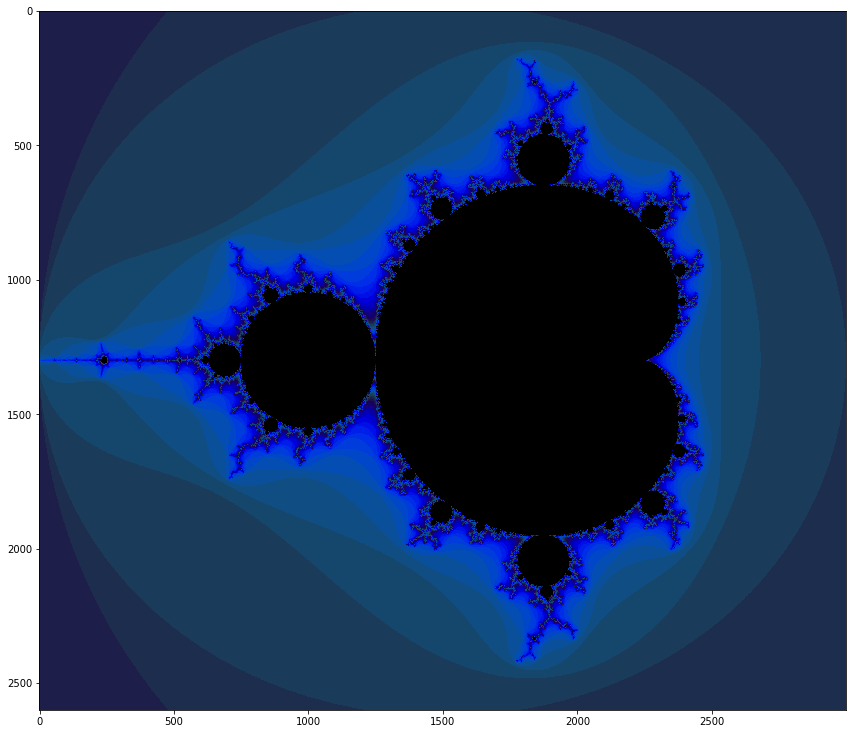

In [28]:
fig = plt.figure(figsize=(16,10))
plt.imshow(processFractal(ns_var.eval()))
plt.tight_layout(pad=0)
plt.show()

#### Zooming in

In [29]:
Y2, X2 = np.mgrid[0.2:0.7:0.0001, 0:0.5:0.0001]
Z2 = X2+1j*Y2

In [30]:
xs_const = tf.constant(Z2.astype(np.complex64))
zs_var = tf.Variable(tf.zeros_like(xs_const))
ns_var = tf.Variable(tf.zeros_like(xs_const, tf.float32))

In [31]:
tf.global_variables_initializer().run()

In [32]:
zs_ = zs_var*zs_var + xs_const
not_diverged = tf.abs(zs_) < 2
step = tf.group( zs_var.assign(zs_), ns_var.assign_add(tf.cast(not_diverged, tf.float32)) )

In [33]:
for i in range(300):
    step.run()

In [34]:
ns_var

<tf.Variable 'Variable_5:0' shape=(5000, 5000) dtype=float32_ref>

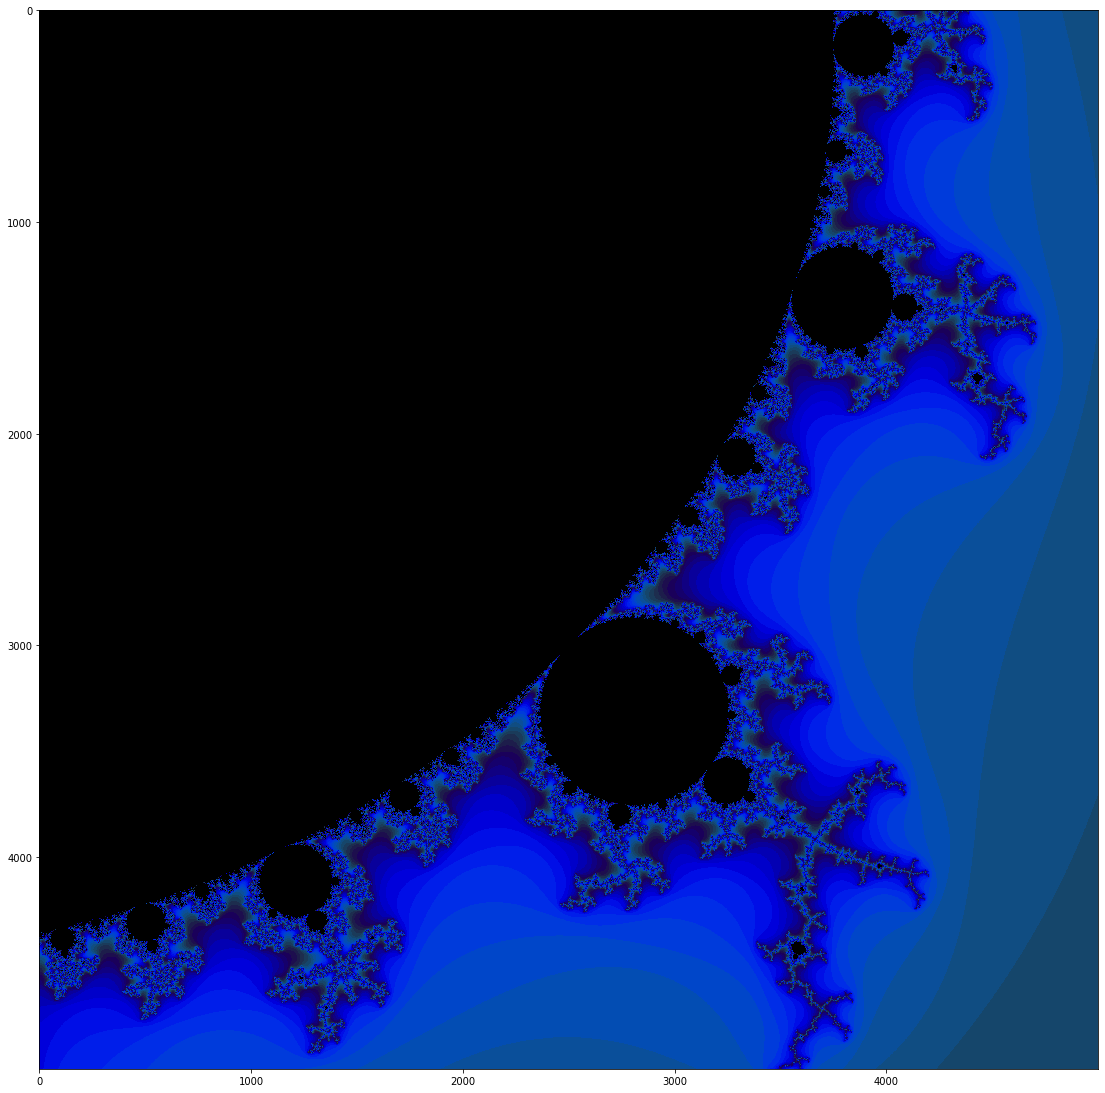

In [35]:
fig = plt.figure(figsize=(15,15))
plt.imshow(processFractal(ns_var.eval()))
plt.tight_layout(pad=0)
plt.show()